In [1]:
import pandas as pd
import json

In [2]:
df_trec = pd.read_parquet("../../../data/metadata_TREC.parquet")
df_ceur = pd.read_parquet("../../../data/metadata_CEUR.parquet")
df_lncs = pd.read_parquet("../../../data/metadata_LNCS.parquet")
df_lncs.loc[df_lncs['ID'] == "lncs_649", 'Section'] = "CLEF at SemEval 2007"

In [3]:
# Adding Influential Citation Counts to the proceeding paper metadata

def add_SemanticCitations(df, path):
    with open(path, 'r', encoding="utf-8") as file:
        SemanticCitations = json.load(file)
    
    citations_semantic = []
    for i in SemanticCitations:
        try:
            citations_semantic.append([i, SemanticCitations[i]["influentialCitationCount"]])
        except:
            print(i)
    df_citations = pd.DataFrame(citations_semantic, columns=["ID", "Citations_semantic"])
    merge = pd.merge(df, df_citations, how="left" , left_on = "ID", right_on="ID")
    return merge

In [5]:
df_lncs = add_SemanticCitations(df_lncs, "../../../data/SemanticScholar_LNCS_additional_metadata.json")
df_trec = add_SemanticCitations(df_trec, "../../../data/SemanticScholar_TREC_additional_metadata.json")
df_ceur = add_SemanticCitations(df_ceur, "../../../data/SemanticScholar_CEUR_additional_metadata.json")

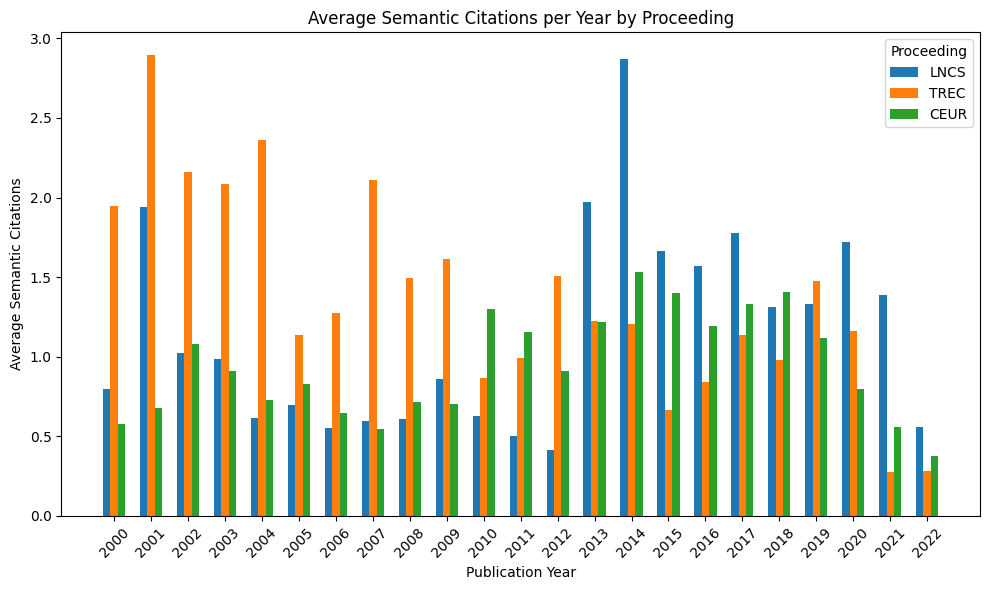

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the average amount of Influential Citation Counts per Year for the three proceedings
lncs_avg_citations = df_lncs.groupby('PubYear')['Citations_semantic'].mean().reset_index()
lncs_avg_citations['Proceeding'] = 'LNCS'

trec_avg_citations = df_trec.groupby('PubYear')['Citations_semantic'].mean().reset_index()
trec_avg_citations['Proceeding'] = 'TREC'

ceur_avg_citations = df_ceur.groupby('PubYear')['Citations_semantic'].mean().reset_index()
ceur_avg_citations['Proceeding'] = 'CEUR'


# Combine the Data
combined_avg_citations = pd.concat([lncs_avg_citations, trec_avg_citations, ceur_avg_citations])
combined_avg_citations['PubYear'] = pd.to_numeric(combined_avg_citations['PubYear'], errors='coerce')

# Create bar plot figure for comparing the three procedings
plt.figure(figsize=(10, 6))

# Create a bar plot for each source
for source in combined_avg_citations['Proceeding'].unique():
    subset = combined_avg_citations[combined_avg_citations['Proceeding'] == source]
    plt.bar(subset['PubYear'] + (0.2 * (combined_avg_citations['Proceeding'].unique().tolist().index(source) - 1)),
            subset['Citations_semantic'], width=0.2, label=source)

plt.xlabel('Publication Year')
plt.ylabel('Average Semantic Citations')
plt.title('Average Semantic Citations per Year by Proceeding')
plt.xticks(combined_avg_citations['PubYear'].unique(), rotation=45)
plt.legend(title='Proceeding')
plt.tight_layout()
plt.savefig('../../../images/influential_citation_count.png', dpi=300)  # Save the figure as a PNG file with 300 dpi

plt.show()